# Thomas Fire Analysis in Santa Barbabra, CA
 
### By: Kristina Glass

Link to GitHub Repository: https://github.com/kristinaglass/presentation-ready-repo


# About

## Purpose

The purpose of this dataset is to explore the impacts of the Thomas Fire in Santa Barbara from December 4, 2017 – March 22, 2018. This dataset explore landcover imagry and air quality

## Highlights of Analysis

## Dataset Description and References

The datasets used include:
- [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov)
- A simplified Landsat raster collected by the Landsat 8 satellite 
- [A shapefile of fire perimeters in California during 2017 from the CA State Geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)
- [A subset of the US Census Bureau's 2016 TIGER database state boundary](https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b)
- And various  datasets included in a 'data' folder


# Importing Data

In [1]:
#import necessary datastes
import pandas as pd
import os
import numpy as np

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


## 1. Exploring Air Quality Index (AQI)

### 1.1 Read in AQI Datasets

In [2]:
#read in 2017 and 2018 daily aqi by county
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

### 1.2 Data Exploration

In [3]:
#view number of objects in aqi_17
print(len(aqi_17))

#view type of aqi_18
print(type(aqi_18))

326801
<class 'pandas.core.frame.DataFrame'>


### 1.3 Data Analysis

In [4]:
#combine both datasets
aqi = pd.concat([aqi_17, aqi_18])

# initial column names: notice caps and spaces (difficult to work with!)
print(aqi.columns, '\n')

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()
print(aqi.columns, '\n')

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')
print(aqi.columns)

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state name', 'county name', 'state code', 'county code', 'date', 'aqi',
       'category', 'defining parameter', 'defining site',
       'number of sites reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


In [5]:
#subset Santa Barbara County from data frame
aqi_sb = aqi[aqi['county_name'] == "Santa Barbara"]
#check new dataframe
aqi_sb
#remove state_name, county_name, state_code, and county_code
aqi_sb = aqi_sb.drop(columns=["state_name", "county_name", "state_code", "county_code"])
#checking new data types
print(aqi_sb.dtypes)

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object


In [6]:
#updating date column to datetime from object
aqi_sb.date = pd.to_datetime(aqi_sb.date)
#check column
aqi_sb.dtypes
#update index
aqi_sb = aqi_sb.set_index("date")
# check if index updated
print(aqi_sb.index)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)


In [7]:
# calculate average over a rolling window
# 5D indicates the window will be over 5 days
aqi_sb.aqi.rolling('5D').mean()

date
2017-01-01    39.000000
2017-01-02    37.500000
2017-01-03    48.666667
2017-01-04    45.000000
2017-01-05    43.400000
                ...    
2018-12-27    38.600000
2018-12-28    38.600000
2018-12-29    38.200000
2018-12-30    37.800000
2018-12-31    38.400000
Name: aqi, Length: 730, dtype: float64

In [8]:
# adding five day average column
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

### 1.4 Plot AQI Data

<AxesSubplot:title={'center':'AQI and 5-Day AQI Average in Santa Barbara'}, xlabel='Year', ylabel='Aqi'>

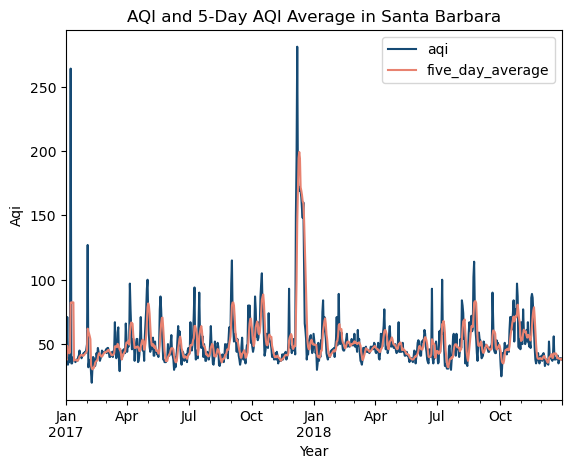

In [9]:
#Plotting AQI and 5 Day Average
#Leave x input blank to plot over the index (date index)
aqi_sb.plot( 
        y= ['aqi', 'five_day_average'], #allows for aqi and 5-day-average to be on same plot
        title = 'AQI and 5-Day AQI Average in Santa Barbara',
        xlabel='Year',
        ylabel='Aqi',        
        color = {'aqi':'#154a74',
                 'five_day_average': '#e88270'
                 }
        )

## 2. Exploring Landsat 8 False Color Image

### 2.1 Read in Landsat and Fire Permimeter Datasets

In [10]:
# set landsat data file path
landsat_fp = os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc')
#import landsat data
landsat = rioxr.open_rasterio(landsat_fp)

# import fire perimeters as ca_fire
ca_fire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')

### 2.2 Data Exploration

In [11]:
#show dataset type of landsat
print(type(landsat))
#show landsat values
landsat.values
#show landsat crs
print(landsat.rio.crs)

<class 'xarray.core.dataset.Dataset'>
EPSG:32611


In [12]:
#find type of ca_fire dataset
print(type(ca_fire))
#check values of ca_fire
ca_fire.values
#show ca_fire crs
print(ca_fire.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
epsg:3857


### 2.3 Data Analysis

In [13]:
# transform ca_fire crs
ca_fire.to_crs(crs = 32611, inplace = True)

#subset ca_fire to Thomas Fire data, create new variable "thomas"
thomas = ca_fire[ca_fire['FIRE_NAME']=="THOMAS"]

In [14]:
#remove unecessary band "band" from landsat dataset
landsat = landsat.squeeze().drop('band')

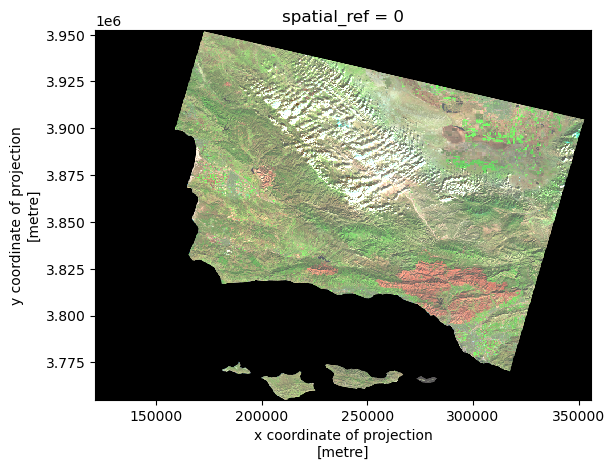

In [15]:
# create landsat false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### 2.4 Plot Landsat Data

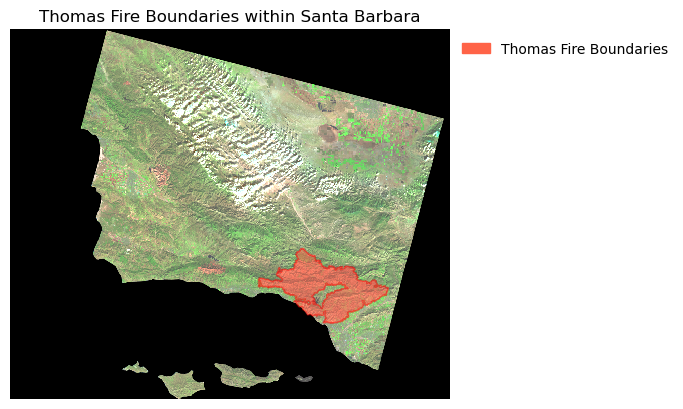

In [16]:
#create plot
fig, ax = plt.subplots()
# --------------------------------------------
#create landsat plot
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
# --------------------------------------------
#create thomas fire area boundaries
thomas.plot(ax=ax, color = 'tomato', alpha = 0.5, edgecolor = "red")
#create thomas fire legend patch
thomas_patch = mpatches.Patch(color='tomato',
                          label='Thomas Fire Boundaries')
# --------------------------------------------
# create plot legend
ax.legend(handles = [thomas_patch], frameon=False, loc='upper left', bbox_to_anchor = (1,1))
#set plot tile
ax.set_title('Thomas Fire Boundaries within Santa Barbara')
#remove axis
ax.set_axis_off()
#show plot
plt.show()